In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import torchmetrics

In [2]:
train = pd.read_csv("../data/arrhythmia/mitbih_train.csv", header = None)
test = pd.read_csv("../data/arrhythmia/mitbih_test.csv", header = None)

# Last column reserved for classes
X_train = torch.tensor(train.iloc[:, :-1].to_numpy()).float()
y_train = torch.tensor(train.iloc[:, -1].to_numpy().astype(np.int64))

X_test = torch.tensor(test.iloc[:, :-1].to_numpy()).float()
y_test = torch.tensor(test.iloc[:, -1].to_numpy().astype(np.int64))

training_data = data_utils.TensorDataset(X_train, y_train)
test_data = data_utils.TensorDataset(X_test, y_test)

In [32]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

for X, y in test_dataloader:
    print("Shape of X [N, P]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, P]:  torch.Size([64, 187])
Shape of y:  torch.Size([64]) torch.int64


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(187, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 5)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=187, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=5, bias=True)
  )
)


In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [25]:
val_accuracy = torchmetrics.Accuracy()

In [23]:
def training(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Set the model in training mode

    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute loss:
        pred = model(X) # This executes fwd function. Don't call fwd directly!
        loss = loss_fn(pred, y)

        # Backpropagation:
        optimizer.zero_grad() # to reset the gradients of model parameters. Gradients by default add up; 
        # to prevent double-counting, we explicitly zero them at each iteration.
        loss.backward() # Compute gradients
        optimizer.step() # Update parameters

        train_loss += loss.item()

        if batch % 100 == 0: # Every 100 batches, report loss
            loss, current = loss.item(), batch * len(X) # item() extracts the loss value as float
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    
    train_loss /= size

    return train_loss


In [34]:
def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Set model in evaluation mode. Disables certain modules such as Dropout
    val_loss, correct = 0, 0
    with torch.no_grad(): # Disable gradient calculation as its not necessary.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    print(correct)

    return val_loss

In [35]:
train_losses = []
val_losses = []
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(training(train_dataloader, model, loss_fn, optimizer))
    val_losses.append(validation(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 1.626198 [    0/87554]
loss: 1.636317 [ 6400/87554]
loss: 1.628998 [12800/87554]
loss: 1.624861 [19200/87554]
loss: 1.635063 [25600/87554]
loss: 1.628865 [32000/87554]
loss: 1.626301 [38400/87554]
loss: 1.637202 [44800/87554]
loss: 1.615523 [51200/87554]
loss: 1.633913 [57600/87554]
loss: 1.638936 [64000/87554]
loss: 1.625148 [70400/87554]
loss: 1.624971 [76800/87554]
loss: 1.631285 [83200/87554]
Test Error: 
 Accuracy: 7.3%, Avg loss: 1.630509 

0.07345148912844875
Epoch 2
-------------------------------
loss: 1.640236 [    0/87554]
loss: 1.631582 [ 6400/87554]
loss: 1.633346 [12800/87554]
loss: 1.632807 [19200/87554]
loss: 1.621848 [25600/87554]
loss: 1.633425 [32000/87554]
loss: 1.623474 [38400/87554]
loss: 1.627222 [44800/87554]
loss: 1.631391 [51200/87554]
loss: 1.629770 [57600/87554]
loss: 1.622229 [64000/87554]
loss: 1.629665 [70400/87554]
loss: 1.638179 [76800/87554]
loss: 1.620262 [83200/87554]
Test Error: 
 Accuracy: 7.3%, Avg los

KeyboardInterrupt: 

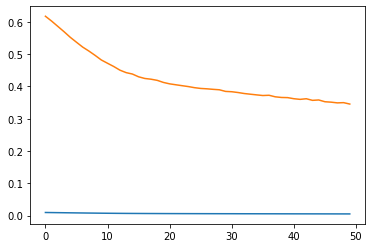

In [15]:
plt.plot(train_losses)
plt.plot(val_losses)